# Midterm Solutions
---

## Question 1
Generate Figure 5.7 in West. EDIT: Show your work, the methodology should be clear to me.


## Solution 1

In [1]:
import sys
sys.path.append("/pithy/code")
from pithy import *
rcParams['figure.figsize'] = (10,10)
%matplotlib inline

![figure 5 7](imgs/west_fig_5_7.png)

The figure illustrates the influence on the addition of a supporting electrolyte on concentrations and system potential copper deposition.

The key to the problem is to realize that 
1. flux $N_1$ must be constant
2. electroneutrality must be obeyed everywhere
3. the concentration of species 1 must be zero at the surface


First we'll create a function that returns concentrations, flux, and phi as function bulk concentrations, valence, temperature, and position, manipulating 5.49

$$\frac{N_1}{D_1}(\delta-x) = 
\left(1-\frac{z_2}{z_1} \right)c_{2,\infty}e^{\left(\frac{-z_2 F \phi}{RT} \right)}+
\left(1-\frac{z_3}{z_1} \right)c_{3,\infty}e^{\left(\frac{-z_3 F \phi}{RT} \right)}-
c_{1,\infty}-c_{2,\infty}-c_{3,\infty}$$


In [2]:
#A manipulation of West Equation 5.49
def solve_all(delta,D1,z1,z2,z3,c1inf,c2inf,c3inf,T,x=0,phi=None):
    
    #define constants
    R = 8.31446
    F = 96487.0
    #define gamma
    gamma = (-z3*c3inf)/(z2*c2inf)

    #Find potential at surface such that c1(x=0) = 0
    phi0 = -((R*T)/((z2-z3)*F))*log(gamma)

    #if phi not passed as argument, find surface properties
    if phi == None: phi = phi0

    c2 = c2inf*exp(-z2*F*phi0/(R*T))
    c3 = c3inf*exp(-z3*F*phi0/(R*T))
    c1 = -(z2*c2+z3*c3)/z1
    Part1 = (1-(z2/z1))*c2inf*exp(-z2*F*phi/(R*T))
    Part2 = (1-(z3/z1))*c3inf*exp(-z3*F*phi/(R*T))
    Part3 = c1inf+c2inf+c3inf
    N = (D1/(delta-x))*(Part1+Part2-Part3)
    return c2,c3,N,phi,c1


#Now Set Constants
c1inf = 1.0 # 1 M Cu2+
z1 = 2.0 #Z_Cu
z2 = -2.0 #Z_SO4
z3 = 1.0 # Z_H
delta = 1e-6 # Thickness of Diffusion Layer in microns
D1 = 1e-6 #Guess at a diffusion coeffieinct

#Sweep a range of solutions concentrations
c3inf = logspace(-5,1,10)

#solve for amount of sulfate using electronuetrailtiy
c2inf = c1inf+c3inf*abs(z2/z3) 
T = 298

Once we set this up, we should be able to ensure that the system obeys electroneutrality...

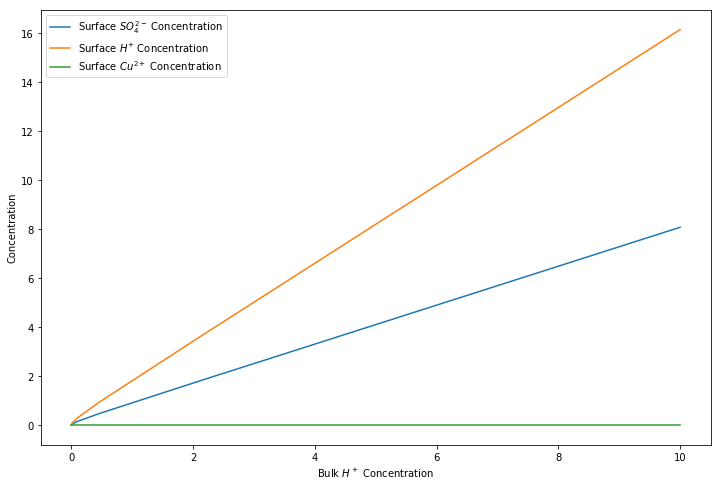

In [3]:
figure(figsize=(12,8))
#Determine surface concentrations as a function of H+
Fluxer = solve_all(delta,D1,z1,z2,z3,c1inf,c2inf,c3inf,T)
plot(c3inf,Fluxer[0],label="Surface $SO_4^{2-}$ Concentration")
plot(c3inf,Fluxer[1],label="Surface $H^{+}$ Concentration")
plot(c3inf,Fluxer[-1],label="Surface $Cu^{2+}$ Concentration")
legend(loc="best",fontsize=10)
xlabel("Bulk $H^+$ Concentration")
ylabel("Concentration")

and it does.

Now we can iterate to explicitly solve $\phi(x)$ which to this point has been implicitly defined.

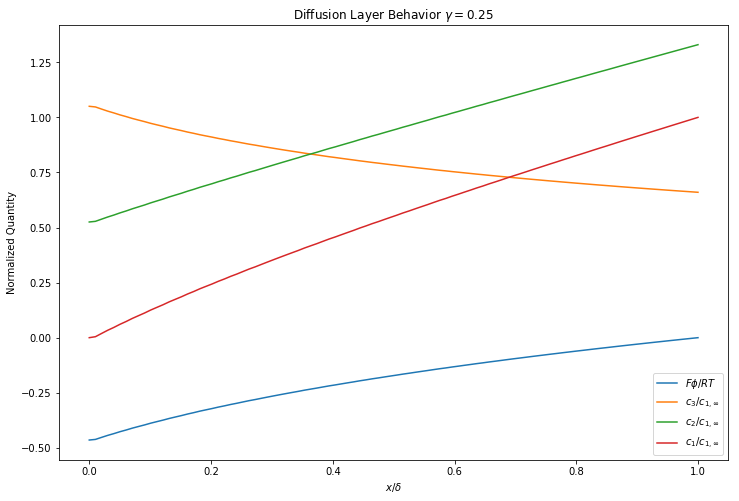

In [4]:
figure(figsize=(12,8))

#define a function that solves for x
def phi(x,phi0=None):
    stuff = solve_all(delta,D1,z1,z2,z3,c1inf,c2inf,c3inf,T)
    N0 = stuff[2] #flux
    
    if phi0 == None: phi0 = stuff[3]    #surface potential

    #Now test a solution against a range of phis from the surface potential to 0 (answer should be in there somewhere)
    testphis = linspace(phi0,0,500)
    N_error = 100 #dummy variable error
    phi_holder = 1000000 #dummy phi 
    
    #Remember, in one dimension, flux everywhere should be equal so we sweep through phis until N(0) = N(x), then we have our correct phi 
    for tp in testphis:
        N_check = solve_all(delta,D1,z1,z2,z3,c1inf,c2inf,c3inf,T,x=x,phi=tp)[2]
        if abs(N_check - N0) < N_error:
            phi_holder = tp
            N_error = abs(N_check - N0)
        if N_error < 1e-2:
            break
    return phi_holder

F = 96487 #Faradays Constant C/mol
R = 8.31446 # Ideal Gas Constant


#Sweep Range of proton concentrations
hs = [.1,.2,.3,.66]


#get some points between 0 and delta
xs = linspace(0,.99999*delta,100)

phiphi = {}

for h in hs:
    c3inf = h #set acidity
    c1inf = 1 #set Cu
    c2inf = c1inf+c3inf*abs(z3/z2) #Solve for sulfates via electroneutrality
    
    #setting phis as a list
    phis = []

    #solve for gamma    
    gamma = abs((z3*c3inf)/(z2*c2inf))
    
    #determine phi from for x = 0 to delta
    phi_base = None
    for x in xs: 
        phi_base = phi(x,phi_base)
        phis.append(phi_base)
    
    phis = array(phis) #make vector
    c2 = c2inf*exp(-z2*F*phis/(R*T)) #Equation 5.43
    c3 = c3inf*exp(-z3*F*phis/(R*T)) #Equation 5.43
    c1 = -(z2*c2+z3*c3)/(z1)         #Equation 5.44

    #store phi values in dictionary
    phiphi[gamma] = phis
    clf()

    #Now Plot!
    plot(xs/delta,F*phis/(R*T),label="$F\phi / RT$")
    plot(xs/delta,c3/c1inf,label="$c_3 / c_{1,\infty}$")
    plot(xs/delta,c2/c1inf,label="$c_2 / c_{1,\infty}$")
    plot(xs/delta,c1/c1inf,label="$c_1 / c_{1,\infty}$")
    legend(loc=4,fontsize=10)
    title("Diffusion Layer Behavior $\gamma = %.2f$" % gamma)
    xlabel("$x/\delta$")
    ylabel("Normalized Quantity")
    

(-3, 1)

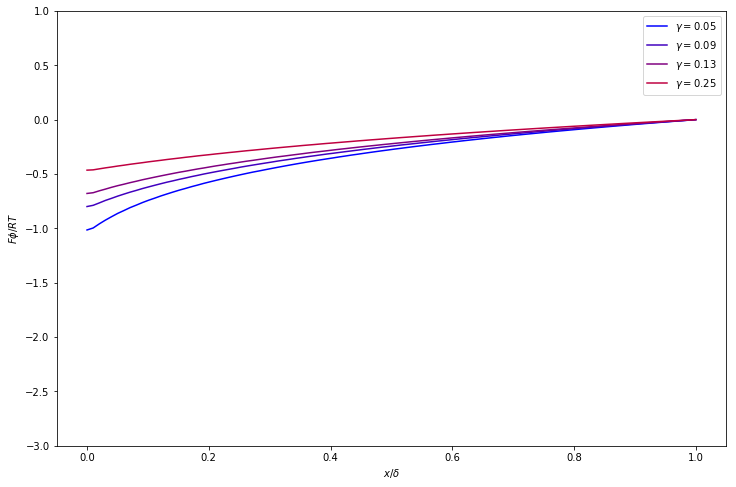

In [5]:
#Extra!  Show all phis(gamma,x) together!
figure(figsize=(12,8))

keys = phiphi.keys()
keys.sort()

#for coloration
count = 0.0
for k in keys:
    #coloring trick
    f = count/len(keys)
    c = (f,0,1-f)
    
    #plot
    plot(xs/delta,F*phiphi[k]/(R*T),color=c,label="$\gamma=%.2f$" % k)
    
    #increment colorizer
    count = count +1

xlabel("$x/\delta$")
ylabel("$F\phi / RT$")
legend(loc="best")
ylim(-3,1)

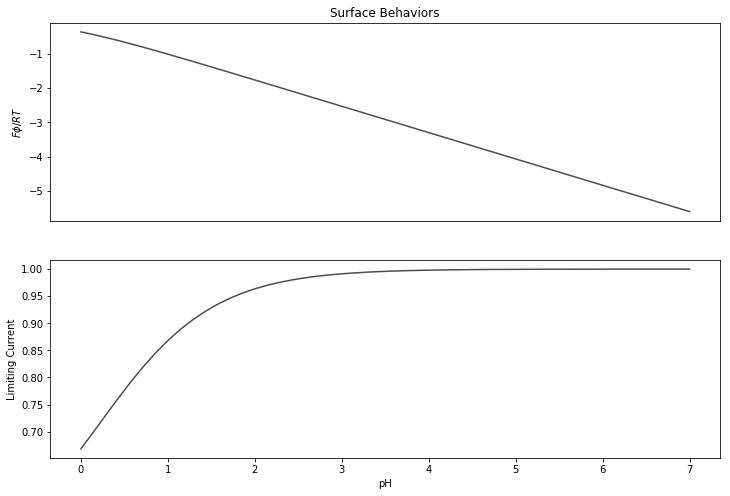

In [6]:
#Extra!  Example surface phi and flux as a function of pH
data = []
for i in logspace(-7,0,50):
    c3inf = i
    c1inf = 1
    c2inf = c1inf+c3inf*abs(z3/z2)
    foo = solve_all(delta,D1,z1,z2,z3,c1inf,c2inf,c3inf,T)
    foo = list(foo)
    data.append(foo)
    

figure(figsize=(12,8))
ph  = -log10(logspace(-7,0,50))
data = array(data).T
subplot(2,1,1)
phi = F*data[3]/(R*T)
ylabel("$F\phi / RT$")
xticks([])
plot(ph,phi,'.3')
title("Surface Behaviors")
subplot(2,1,2)
flux= abs(data[2])
ylabel("Limiting Current")
xlabel("pH")
plot(ph,flux/max(flux),'.3')

## Question 2
Can a lithium ion battery, or a lithium metal battery, full charged, use an electrolyte with any supporting cations (i.e. a ternary electrolyte)? Why or why not?

## Solution 2

Since there is no metal no more reducing than lithium, then the reaction

$$nLi (s) + M^{n+} \rightarrow M(s) + nLi^+$$

will _always_ proceed.

So the reason we cannot support a lithium ion/lithium metal battery electrolyte with a secondary cation is that it will attack the negative electrode leading to fast self-discharge.

If the kinetics are slow, it will take a while to happen and not be too dangerous, but as of now we have no way of internally reversing the above attack.
